# Downloading and preparing features and ground truth for deep neural network machine learning

## Load the ground truth
..from https://pubs.usgs.gov/of/2013/1280/GIS_and_Maps/Chapter_M1_deliverable_78-Iron_oxide_copper-gold_deposits_(IOCG)/Data/IOCG_Permissive_Tracts_IRM.zip  
Source: https://pubs.usgs.gov/publication/ofr20131280 - Second Projet de Renforcement Institutionnel du Secteur Minier de la République Islamique de Mauritanie (PRISM-II) Phase V

In [1]:
import geopandas as gpd
# downloaded 
filename = 'IOCG_Permissive_Tracts_IRM.zip'

gdf = gpd.read_file(filename) 
gdf.head()

,Tract_Name,Commodity,Dep_Type,Remarks,Nom_zone,Matière,Genre,Remarques,Date,Length,Area,geometry
0,IOCG-5 - Archean,"Au, Fe, Cu",IOCG,Permissive host rocks; Archean supracrustal ro...,IOCG-5 - Archean,"Au, Fe, Cu",IOCG,Roches hôtes favorables; roches supracrustales...,2012,9.776279e+06,3.259639e+09,"MULTIPOLYGON (((-302791.511 2212021.554, -3029..."
1,IOCG-3 - Bou Lanouar 1,"Au, Fe, Cu",IOCG,Potential permissive host rocks; greenstone-BI...,IOCG-3 - Bou Lanouar 1,"Au, Fe, Cu",IOCG,Roches hôtes favorables potentielles; séquence...,2012,1.092005e+05,6.202284e+08,"POLYGON ((-523787.974 2354802.357, -524422.975..."
2,IOCG-4 - Bou Lanouar 2,"Au, Fe, Cu",IOCG,Potential permissive host rocks; greenstone-BI...,IOCG-4 - Bou Lanouar 2,"Au, Fe, Cu",IOCG,Roches hôtes favorables potentielles; séquence...,2012,1.110664e+05,6.148523e+08,"POLYGON ((-520827.378 2343209.854, -518530.066..."
3,IOCG-2 - Akjoujt 2,"Au, Fe, Cu",IOCG,Potential permissive host rocks; greenstone-BI...,IOCG-2 - Akjoujt 2,"Au, Fe, Cu",IOCG,Roches hôtes favorables potentielles; séquence...,2012,1.449805e+05,5.147664e+08,"POLYGON ((-346909.569 2158428.415, -346900.517..."
4,IOCG-1 - Akjoujt 1,"Au, Fe, Cu",IOCG,Permissive host rocks; Archean Oumachouneima G...,IOCG-1 - Akjoujt 1,"Au, Fe, Cu",IOCG,Roches hôtes favorables; Groupe Archéen d'Ouma...,2012,4.268688e+05,3.214777e+09,"POLYGON ((-388450.914 2216361.059, -388425.399..."


## View the polygons

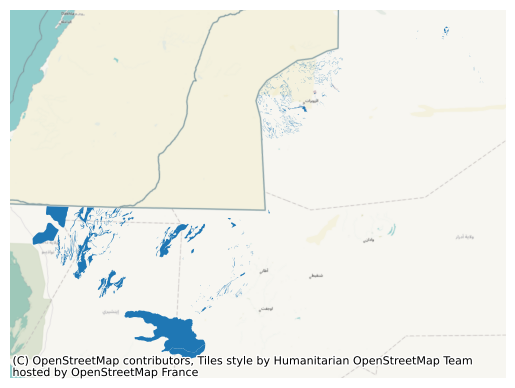

In [24]:
import matplotlib.pyplot as plt
import contextily as ctx

f, ax = plt.subplots(1)
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
gdf.plot(ax=ax)

# Add OpenStreetMap as background
ctx.add_basemap(ax=ax, crs=gdf.crs.to_string(), zoom=8)

plt.show()

In [13]:
akjoujt1 = gdf.loc[gdf['Tract_Name'] == 'IOCG-1 - Akjoujt 1']
akjoujt1 = akjoujt1.to_crs(akjoujt1.estimate_utm_crs())
print(akjoujt1.crs)
print(akjoujt1.Tract_Name.values[0])
print(akjoujt1.Remarks.values[0])
akjoujt1.head()

EPSG:32628
IOCG-1 - Akjoujt 1
Permissive host rocks; Archean Oumachouneima Group, presence of known IOCG deposits and prospects.


,Tract_Name,Commodity,Dep_Type,Remarks,Nom_zone,Matière,Genre,Remarques,Date,Length,Area,geometry
4,IOCG-1 - Akjoujt 1,"Au, Fe, Cu",IOCG,Permissive host rocks; Archean Oumachouneima G...,IOCG-1 - Akjoujt 1,"Au, Fe, Cu",IOCG,Roches hôtes favorables; Groupe Archéen d'Ouma...,2012,426868.753772,3.214777e+09,"POLYGON ((530165.978 2212078.479, 530192.265 2..."


## View ground truth polygon

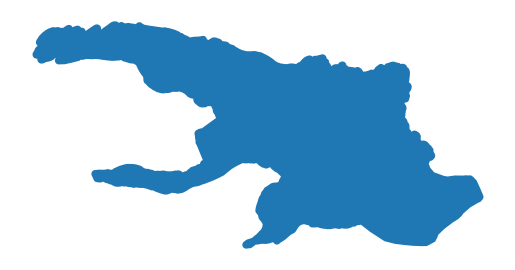

In [15]:
f, ax = plt.subplots(1)
akjoujt1.plot(ax=ax)
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Save ground truth as png 

In [33]:
import numpy as np
from PIL import Image
import geopandas as gpd
import rasterio
from rasterio.features import geometry_mask

bounds = akjoujt1.total_bounds
width = 11758
height = 5976
transform = rasterio.transform.from_bounds(*bounds, width=width, height=height)
out_shape = (height, width)

# Rasterize the GeoDataFrame
mask = geometry_mask(akjoujt1.geometry, transform=transform, invert=True, out_shape=out_shape)

# Prepare data for a three-band image
red_band = (mask.astype(int) * 255).astype(np.uint8)  # Convert boolean to int, scale up to 255, and convert to uint8
green_band = np.full_like(red_band, 255, dtype=np.uint8)  # Set to 255
blue_band = np.full_like(red_band, 255, dtype=np.uint8)  # Set to 255

# Stack bands
three_band_image = np.stack((red_band, green_band, blue_band), axis=-1)

# Convert the three-band image array to a Pillow Image object
image = Image.fromarray(three_band_image)

image.save('ground_truth.png')
image

## Load a data cube from Sentinel 2 L2A collection from Copernicus
The difference between L1C and L2A images is that L2A has been atmospherically corrected. 

In [37]:
import openeo
import xarray
import matplotlib.pyplot as plt

In [38]:
connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.1/' with NullAuth>

In [39]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.1/' with OidcBearerAuth>

## Data Loading

With our authenticated connection, we can now start loading a data collection data to build a `DataCube`,
filtered according to specific spatio-temporal constraints:

In [40]:
bbox = {
        "west": float(akjoujt1.bounds.minx.iloc[0]),
        "south": float(akjoujt1.bounds.miny.iloc[0]),
        "east": float(akjoujt1.bounds.maxx.iloc[0]),
        "north": float(akjoujt1.bounds.maxy.iloc[0]),
        "crs": str(akjoujt1.crs)
}
bbox

{'west': 507709.02813260024,
 'south': 2153255.1564062657,
 'east': 625182.1379139412,
 'north': 2212478.3663099995,
 'crs': 'EPSG:32628'}

In [41]:
# Pick geology bands based on https://gisgeography.com/sentinel-2-bands-combinations/ and Scene Classification Layer (SCL) for cloud masking
bands = ["B12", "B11", "B02", "SCL"]

s2_cube_l2a = connection.load_collection(
    "SENTINEL2_L2A",
    temporal_extent=("2023-01-01", "2023-01-10"),
    spatial_extent=bbox,
    bands=bands,
    max_cloud_cover=10,
)

## Data Processing


Let's include a bit of extra data processing.
We'll build a naive composite image by taking the temporal maximum:

In [43]:
composite = s2_cube_l2a.max_time()

### Cloud masking

In general, to make the raw data more useful, we typically want remove the cloud pixels and only work with non-cloud data.
It is very common for earth observation data to have separate masking layers that for instance indicate whether a pixel is covered by a (type of) cloud or not.
For Sentinel-2, one such layer is the "scene classification" layer (band name "SCL") generated by the Sen2Cor algorithm.

With openEO and the openEO Python client library, 
we can take this "SCL" band (which we already included before in the `load_collection` call)
and apply cloud masking as follows.

First we build a binary cloud mask from the SCL values 3 (cloud shadows), 8 (cloud medium probability) and 9 (cloud high probability):

In [45]:
scl_band = s2_cube_l2a.band("SCL")
cloud_mask = (scl_band == 3) | (scl_band == 8) | (scl_band == 9)

# TODO: TEMP WORKAROUND FOR OFFSET ERROR ON SCL BAND
cloud_mask = (scl_band == 3 - 1000) | (scl_band == 8 - 1000) | (scl_band == 9 - 1000)

Before we can apply this mask to the cube we have to resample it, as the “SCL” layer has a “ground sample distance” of 20 meter, while it is 10 meter for the “B02”, “B03” and “B04” bands. 
We can easily do the resampling by referring directly to the data cube to mask.

In [46]:
cloud_mask = cloud_mask.resample_cube_spatial(s2_cube_l2a)

Apply the cloud mask, and build the composite again:

In [47]:
cube_masked = s2_cube_l2a.mask(cloud_mask)

composite_masked = cube_masked.max_time()

Download the result and visualize it.

In [ ]:
composite_masked.download("load-composite-masked-geology-bands.nc")

In [49]:
ds = xarray.load_dataset("load-composite-masked-geology-bands.nc")

In [50]:
# Convert xarray DataSet to a (bands, x, y) DataArray
data = ds[["B12", "B11", "B02"]].to_array(dim="bands")
data.shape


(3, 5923, 11749)

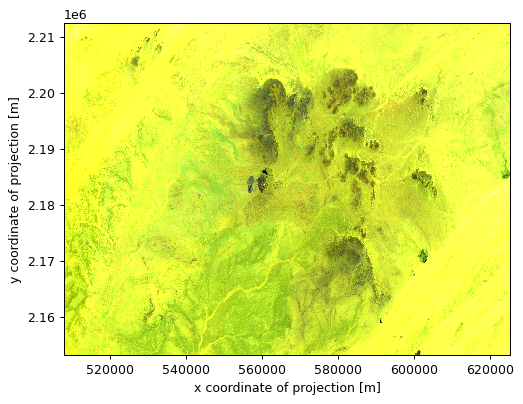

In [63]:
fig, ax = plt.subplots(ncols=1, dpi=90)
data.plot.imshow(vmin=0, vmax=5000, ax=ax)

<Axes: xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

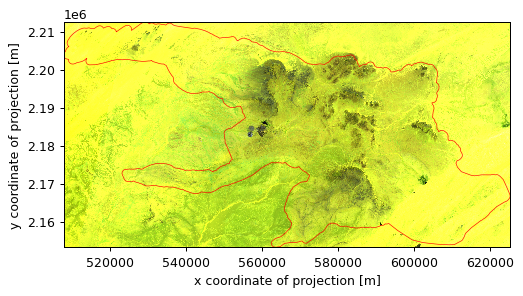

In [64]:
fig, ax = plt.subplots(ncols=1, dpi=90)
data.plot.imshow(vmin=0, vmax=5000, ax=ax)
akjoujt1.plot(ax=ax, edgecolor='red', linewidth=0.5, facecolor='none')


## Convert NETCDF to png

Scaling/downsampling values for faster (but less accurate) machine learning input

In [ ]:

# gdal_translate -of GTiff NETCDF:"load-composite-masked-geology-bands.nc":B12 band_B12.tif
# gdal_translate -of GTiff NETCDF:"load-composite-masked-geology-bands.nc":B11 band_B11.tif
# gdal_translate -of GTiff NETCDF:"load-composite-masked-geology-bands.nc":B02 band_B02.tif

# gdal_merge.py -separate -o merged.tif band_B12.tif band_B11.tif band_B02.tif

# gdal_translate -of PNG -scale 0 5000 0 255 -ot Byte merged.tif SENTINEL2_L2A-B12-B11-B02.png

## Verify features and ground truth

In [66]:
from PIL import Image

img = Image.open('SENTINEL2_L2A-B12-B11-B02.png')
print(img.size)


(11758, 5976)


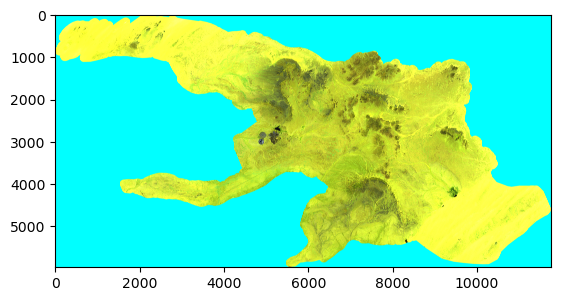

In [68]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the images
img = Image.open('SENTINEL2_L2A-B12-B11-B02.png')
ground_truth = Image.open('ground_truth.png')

# Resize the ground truth image to match the size of the Sentinel-2 image
ground_truth_resized = ground_truth.resize(img.size)

# Make white pixels transparent in the ground truth image
ground_truth_transparent = ground_truth_resized.convert('RGBA')
data = ground_truth_transparent.getdata()
new_data = []
for item in data:
    if item[0] == 255 and item[1] == 255 and item[2] == 255:
        new_data.append((255, 255, 255, 0))
    else:
        new_data.append(item)
ground_truth_transparent.putdata(new_data)

# Overlay the two images
result = Image.alpha_composite(img.convert('RGBA'), ground_truth_transparent)

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the image
ax.imshow(result)



Above, the overlay cyan area is ground truth 0 - no permissive tracts, the transparent area is ground truth 1 - permissive tracts.

## On the mahine learning pipeline

An existing machine learning pipeline was used for segmentation.  
Article: https://comserv.cs.ut.ee/ati_thesis/datasheet.php?id=77501  
Part of the code: https://github.com/arnelism/testis_thesis  

ML Notebook customized for this hackathon https://colab.research.google.com/drive/17skXJ0zqbeVSgMuX4FoNX575AxKXQ7Le?usp=sharing

## Future work to increase accuracy

### Increase the number of training samples by increasing the land area
As was shown in the beginning of this notebook, only a small part of the IOCG permissive trackts (one polygon) was chosen initially.  
Given more time, a bigger dataset can be used to train a better model.

### More features
The deliverable 69 and 79 documents from [the PRISM-II project](https://pubs.usgs.gov/publication/ofr20131280) suggest that a combination of visible, near-infrared, shortwave infrared, mid-infrared, thermal infrared, and shortwave infrared imagery may be useful for predicting IOCG-type gold deposits in Mauritania.

#### Increase the number of bands
Only three bands (B12, B11, B2)- "The geology band combination" were chosen as features (input for training and prediction).  
With more features, like all the bands of Sentinel 2 and indexes like Vegetation Index (B8-B4)/(B8+B4) added the model may learn to predict better.  

#### Use more datasets - add ASTER data
As per https://www.nature.com/articles/s41598-023-34531-y, integrating ASTER and Sentinel 2 data is recommended for gold deposit exploration as it allows for proper detection and characterization of hydrothermal alteration zones. 

## Change the machine learning pipeline
### Accept a more accurate input
In this initial work, the band value ranges were downsampled and clipped to a PNG format, which reduces accuracy.  
By changing the machine learning pipeline to accept a wider range of values using NETCDF of tiff format, there is yet again a higher chance for a more accurate model.

### Increase the patch size
The current training patch size of 512x512 is too small - the model lacks context to be able to learn the relations between different patterns. Imagine watching an IMAX screen sitting 1m away from the screen.

### Change the underlying ML algorithm
Use something simpler than Neural Net. Random forest?

### Increase the prediction patch size
Currently, the predictions are per-pixel. Can the prediction patch size be increased while keeping the granularity of input?

## Finish the whole pipeline
Automatically measuring the results is still to be finished.  
Calculate the number of TP, TN, FP and FN based on the predicted image and the clip from ground_truth.png to get F-1 score and precision, recall.  